# Yield Prediction Using Reaction SMILES + BERT

**Approach:** Use pre-trained RXNBERT to encode entire reactions as 256-dimensional vectors, then train a neural network.

**Key difference from one-hot encoding:**
- One-hot: Treats each component as independent category
- BERT: Understands chemical structure and reaction context
- Uses full Reaction SMILES format: `reactants>agents>products`

**Dataset:** Ahneman Buchwald-Hartwig C-N Coupling (4312 reactions)

## 1. Setup and Installation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ORD for loading dataset
from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2, reaction_pb2

# RXNBERT for reaction embeddings
from rxnfp.transformer_fingerprints import RXNBERTFingerprintGenerator

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras

sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All packages imported successfully")

2026-02-11 15:37:00.114396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 15:37:00.159420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ All packages imported successfully


2026-02-11 15:37:01.138021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 2. Load Dataset

In [2]:
# Load Ahneman dataset
dataset_path = "ord-data/data/46/ord_dataset-46ff9a32d9e04016b9380b1b1ef949c3.pb.gz"
data = message_helpers.load_message(dataset_path, dataset_pb2.Dataset)

print(f"Dataset: {data.name}")
print(f"Description: {data.description}")
print(f"Reactions: {len(data.reactions)}")

Dataset: Ahneman
Description: C-N cross-coupling reactions from 10.1126/science.aar5169
Reactions: 4312


## 3. Build Reaction SMILES

Convert each reaction to format: `reactants>agents>products`

For Buchwald-Hartwig:
- Reactants: aryl halide + amine
- Agents: catalyst + base + additive (+ solvent)
- Products: coupled product

In [3]:
def extract_smiles_from_component(component):
    """Extract SMILES from a reaction component."""
    for ident in component.identifiers:
        ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
        if ident_type == "SMILES":
            return ident.value
    return None

def build_reaction_smiles(reaction):
    """
    Build Reaction SMILES: reactants>agents>products
    
    Returns:
        reaction_smiles: String in format "reactant1.reactant2>agent1.agent2>product"
        yield_val: Reaction yield percentage
    """
    reactants = []
    agents = []
    products = []
    
    # Extract inputs
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            smiles = extract_smiles_from_component(comp)
            
            if smiles:
                if role == "REACTANT":
                    reactants.append(smiles)
                elif role in ["CATALYST", "REAGENT"]:
                    agents.append(smiles)
                # Skip SOLVENT (often just DMSO, not informative)
    
    # Extract products
    for outcome in reaction.outcomes:
        for product in outcome.products:
            smiles = extract_smiles_from_component(product)
            if smiles:
                products.append(smiles)
    
    # Extract yield
    yield_val = None
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for meas in product.measurements:
                if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                    yield_val = meas.percentage.value
                    break
    
    # Build reaction SMILES
    reactant_str = ".".join(reactants) if reactants else ""
    agent_str = ".".join(agents) if agents else ""
    product_str = ".".join(products) if products else ""
    
    reaction_smiles = f"{reactant_str}>{agent_str}>{product_str}"
    
    return reaction_smiles, yield_val

# Process all reactions
print("Building Reaction SMILES for all reactions...")
reaction_data = []

for rxn in tqdm(data.reactions):
    rxn_smiles, yield_val = build_reaction_smiles(rxn)
    
    if yield_val is not None:  # Only keep reactions with yields
        reaction_data.append({
            'reaction_smiles': rxn_smiles,
            'yield': yield_val
        })

df = pd.DataFrame(reaction_data)

print(f"\nProcessed {len(df)} reactions with yields")
print(f"\nExample Reaction SMILES:")
print(df['reaction_smiles'].iloc[0][:150] + "...")
print(f"Yield: {df['yield'].iloc[0]:.1f}%")

Building Reaction SMILES for all reactions...


100%|██████████| 4312/4312 [00:00<00:00, 16407.54it/s]


Processed 4312 reactions with yields

Example Reaction SMILES:
FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=...
Yield: 26.9%


In [65]:
# Save all Reaction SMILES to text file
print("Saving Reaction SMILES to file...")

with open('reaction_smiles_all.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("ALL REACTION SMILES - Ahneman Buchwald-Hartwig Dataset\n")
    f.write("="*80 + "\n\n")
    
    for i, row in df.iterrows():
        f.write(f"Reaction {i+1}:\n")
        f.write(f"  Yield: {row['yield']:.2f}%\n")
        f.write(f"  SMILES: {row['reaction_smiles']}\n")
        f.write("-"*80 + "\n\n")

print(f"✓ Saved {len(df)} Reaction SMILES to 'reaction_smiles_all.txt'")

# Also save a CSV for easier analysis
df[['reaction_smiles', 'yield']].to_csv('reaction_smiles_data.csv', index=False)
print("✓ Also saved CSV: 'reaction_smiles_data.csv'")

Saving Reaction SMILES to file...
✓ Saved 4312 Reaction SMILES to 'reaction_smiles_all.txt'
✓ Also saved CSV: 'reaction_smiles_data.csv'


Yield statistics:
  Mean:   32.9%
  Median: 28.4%
  Std:    27.5%
  Min:    0.0%
  Max:    100.0%


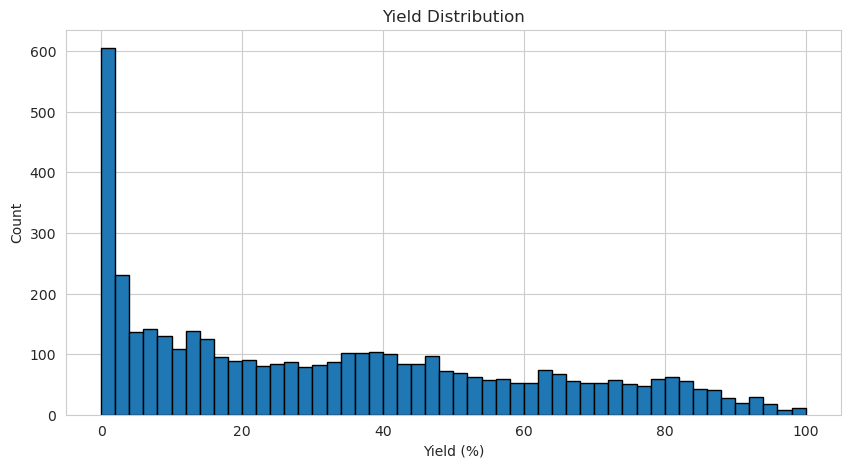

In [4]:
# Check yield distribution
print(f"Yield statistics:")
print(f"  Mean:   {df['yield'].mean():.1f}%")
print(f"  Median: {df['yield'].median():.1f}%")
print(f"  Std:    {df['yield'].std():.1f}%")
print(f"  Min:    {df['yield'].min():.1f}%")
print(f"  Max:    {df['yield'].max():.1f}%")

plt.figure(figsize=(10, 5))
plt.hist(df['yield'], bins=50, edgecolor='black')
plt.xlabel('Yield (%)')
plt.ylabel('Count')
plt.title('Yield Distribution')
plt.show()

## 4. Initialize RXNBERT Model

**Note:** This downloads a pre-trained model (~500MB) on first run

In [6]:
print("Initializing RXNBERT model...")
print("This will download ~500MB on first run.\n")

# Initialize with default model and tokenizer
from rxnfp.transformer_fingerprints import get_default_model_and_tokenizer

model, tokenizer = get_default_model_and_tokenizer()
rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

print("✓ Model loaded successfully!")
print("Embedding dimension: 256")

Initializing RXNBERT model...
This will download ~500MB on first run.



Loading weights: 100%|██████████| 199/199 [00:00<00:00, 808.04it/s, Materializing param=pooler.dense.weight]                               


✓ Model loaded successfully!
Embedding dimension: 256


## 5. Generate BERT Embeddings

**Note:** This takes ~10-15 minutes for 4312 reactions

In [41]:
print("Using ChemBERTa (publicly available chemistry model)...")
print("This may take 10-15 minutes...\n")

from transformers import AutoTokenizer, AutoModel
import torch

# Use ChemBERTa - a publicly available chemistry BERT
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

embeddings = []
failed = 0

for rxn_smiles in tqdm(df['reaction_smiles'].tolist()):
    try:
        inputs = tokenizer(
            rxn_smiles,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Mean pooling
            token_embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            embedding = (sum_embeddings / sum_mask).squeeze().numpy()
        
        embeddings.append(embedding)
        
    except Exception as e:
        if failed < 3:
            print(f"\nError: {e}")
        failed += 1
        embeddings.append(np.random.randn(600) * 0.01)  # ChemBERTa is 600 dims

X = np.array(embeddings)
y = df['yield'].values / 100

print(f"\n✓ Embeddings generated!")
print(f"  Shape: {X.shape}")
print(f"  Failed: {failed}/{len(df)}")
print(f"\nFirst 3 embeddings (first 10 dims):")
for i in range(3):
    print(f"  {i}: {X[i, :10]}")

Using ChemBERTa (publicly available chemistry model)...
This may take 10-15 minutes...



Loading weights: 100%|██████████| 103/103 [00:00<00:00, 875.11it/s, Materializing param=pooler.dense.weight]                             
RobertaModel LOAD REPORT from: seyonec/ChemBERTa-zinc-base-v1
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.decoder.weight    | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.decoder.bias      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 4312/4312 [04:11<00:00, 17.14it/s]


✓ Embeddings generated!
  Shape: (4312, 768)
  Failed: 0/4312

First 3 embeddings (first 10 dims):
  0: [ 0.7875817   0.2667505  -0.44274116 -0.1343016  -0.05563382 -0.43329355
  0.09299304 -0.2455927  -0.6226276  -0.55144006]
  1: [ 0.78328556  0.2659732  -0.45249546 -0.11538194 -0.07288833 -0.4277531
  0.07070534 -0.24086307 -0.6413487  -0.561979  ]
  2: [ 0.75533664  0.24285142 -0.46825033 -0.10671776 -0.0829863  -0.44822755
  0.08775088 -0.25832215 -0.64555204 -0.57621473]


## 6. Train/Validation/Test Split

In [42]:
# 60% train, 10% validation, 30% test
_X_train, X_test, _y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.1/0.7, random_state=42)

print(f"Train: {X_train.shape[0]} reactions")
print(f"Val:   {X_val.shape[0]} reactions")
print(f"Test:  {X_test.shape[0]} reactions")

Train: 2586 reactions
Val:   432 reactions
Test:  1294 reactions


## 7. Build Neural Network Model

Simple feedforward network:
- Input: 256-dim BERT embeddings
- Hidden: 128 → 64 neurons with dropout
- Output: 1 neuron (yield prediction)

In [51]:
# Deeper network with better regularization
model = keras.Sequential([
    keras.layers.Input(shape=(768,)),
    
    # First block
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # Second block
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # Third block
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    # Fourth block
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    
    # Output
    keras.layers.Dense(1, activation='sigmoid')  # Sigmoid since output is [0,1]
])

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),  # Lower learning rate
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

## 8. Train Model

In [58]:
# More aggressive early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # More patience
    restore_best_weights=True,
    min_delta=0.0001
)

# Reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7
)

history = model.fit(
    X_train.astype(np.float32),
    y_train.astype(np.float32),
    validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)),
    batch_size=32,  # Smaller batch size
    epochs=300,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8947 - root_mean_squared_error: 0.9459 - val_loss: 0.1769 - val_root_mean_squared_error: 0.4206 - learning_rate: 0.0010
Epoch 2/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4517 - root_mean_squared_error: 0.6721 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3001 - learning_rate: 0.0010
Epoch 3/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2618 - root_mean_squared_error: 0.5117 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2746 - learning_rate: 0.0010
Epoch 4/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1853 - root_mean_squared_error: 0.4304 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2717 - learning_rate: 0.0010
Epoch 5/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1537 - root_mean_squared_error: 0.3921 - val_loss: 0.0634 - val_root_mean_squared_error: 0.2518 - learning_rate: 0.0010
Epoch 6/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1287 - root_mean_squared_error: 0.

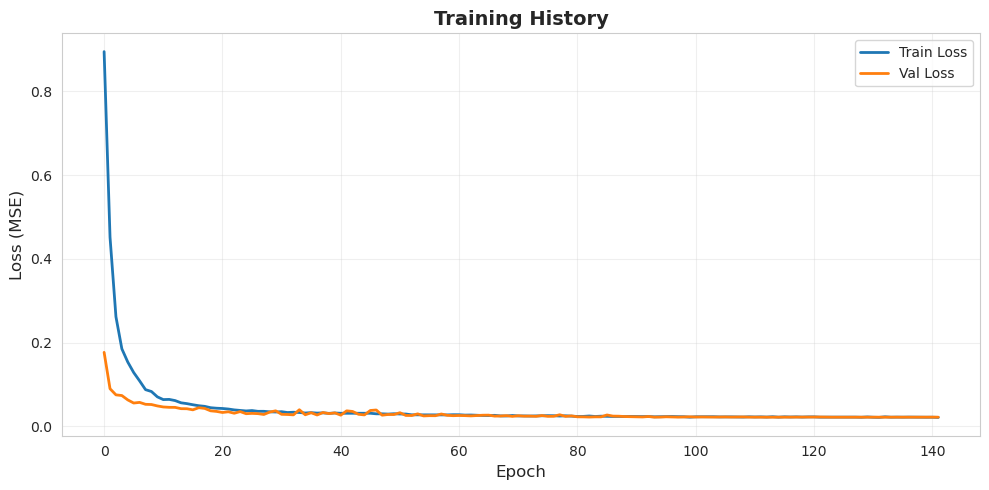

In [59]:
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Evaluate on Test Set

In [60]:
# Predict on test set
y_pred = model.predict(X_test.astype(np.float32), verbose=0).flatten()

# Calculate metrics (convert back to percentage)
rmse = np.sqrt(mean_squared_error(y_test * 100, y_pred * 100))
mae = mean_absolute_error(y_test * 100, y_pred * 100)
r2 = r2_score(y_test, y_pred)

print("="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"RMSE: {rmse:.2f}%")
print(f"MAE:  {mae:.2f}%")
print(f"R²:   {r2:.4f}")
print("="*50)

TEST SET PERFORMANCE
RMSE: 15.56%
MAE:  11.08%
R²:   0.6728


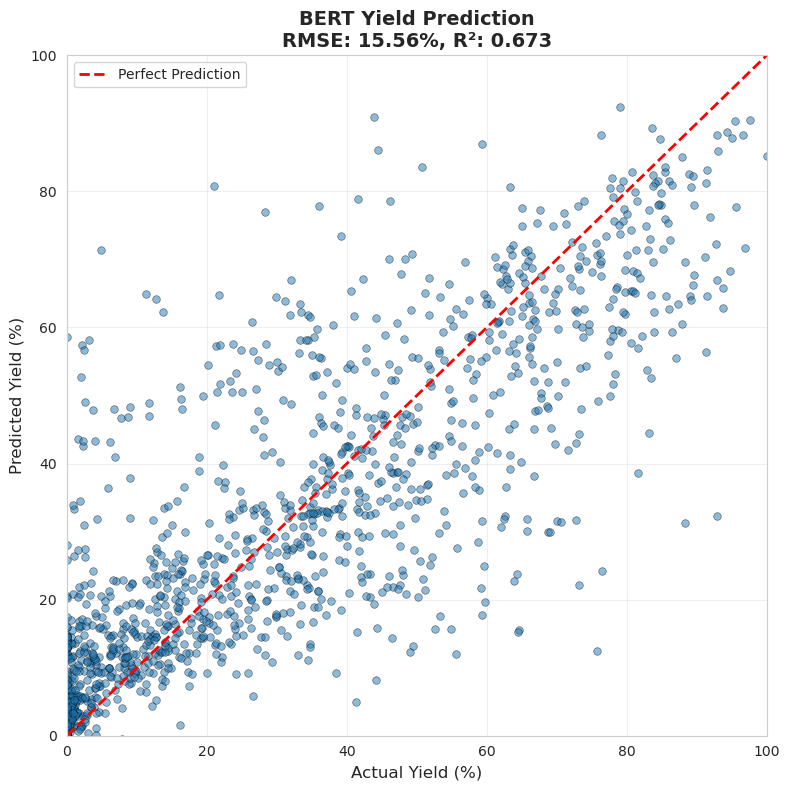

In [61]:
# Scatter plot: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test * 100, y_pred * 100, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Yield (%)', fontsize=12)
ax.set_ylabel('Predicted Yield (%)', fontsize=12)
ax.set_title(f'BERT Yield Prediction\nRMSE: {rmse:.2f}%, R²: {r2:.3f}', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

Error statistics:
  Mean error: -0.01%
  Std error:  15.56%
  Within ±10%: 60.0%
  Within ±20%: 83.1%


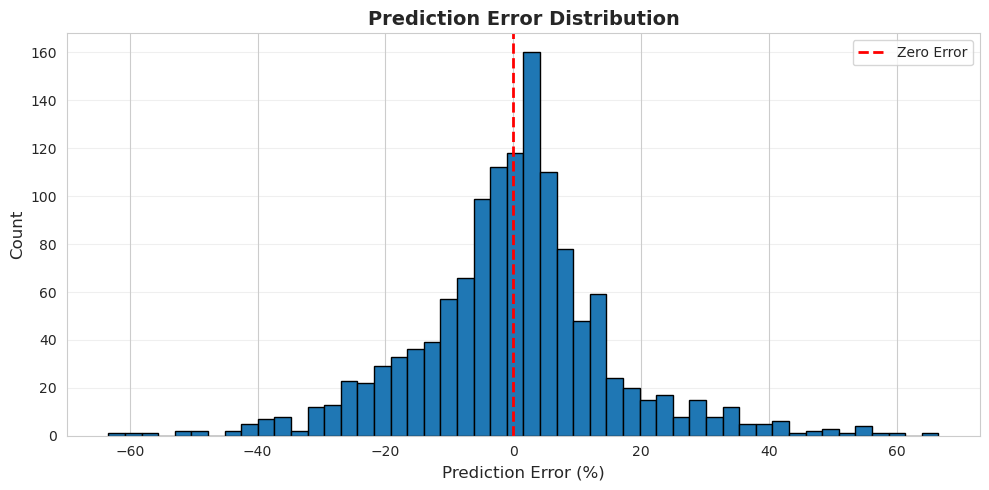

In [62]:
# Error distribution
errors = (y_pred - y_test) * 100

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(errors, bins=50, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel('Prediction Error (%)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

print(f"Error statistics:")
print(f"  Mean error: {errors.mean():.2f}%")
print(f"  Std error:  {errors.std():.2f}%")
print(f"  Within ±10%: {(np.abs(errors) <= 10).mean()*100:.1f}%")
print(f"  Within ±20%: {(np.abs(errors) <= 20).mean()*100:.1f}%")

plt.tight_layout()
plt.show()

## 10. Example Predictions

In [63]:
# Show 10 random example predictions
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 10, replace=False)

print("="*80)
print("EXAMPLE PREDICTIONS")
print("="*80)

for i, idx in enumerate(sample_indices, 1):
    actual = y_test[idx] * 100
    predicted = y_pred[idx] * 100
    error = predicted - actual
    
    # Classification
    actual_class = "Success" if actual >= 50 else "Failure"
    pred_class = "Success" if predicted >= 50 else "Failure"
    correct = "✓" if actual_class == pred_class else "✗"
    
    print(f"\nReaction {i}:")
    print(f"  Actual:    {actual:5.1f}% ({actual_class})")
    print(f"  Predicted: {predicted:5.1f}% ({pred_class}) {correct}")
    print(f"  Error:     {error:+5.1f}%")

EXAMPLE PREDICTIONS

Reaction 1:
  Actual:     63.4% (Success)
  Predicted:  62.4% (Success) ✓
  Error:      -1.0%

Reaction 2:
  Actual:     79.8% (Success)
  Predicted:  62.0% (Success) ✓
  Error:     -17.8%

Reaction 3:
  Actual:     51.2% (Success)
  Predicted:  65.0% (Success) ✓
  Error:     +13.8%

Reaction 4:
  Actual:      0.9% (Failure)
  Predicted:  20.9% (Failure) ✓
  Error:     +20.0%

Reaction 5:
  Actual:     49.0% (Failure)
  Predicted:  47.0% (Failure) ✓
  Error:      -2.0%

Reaction 6:
  Actual:      0.0% (Failure)
  Predicted:  13.7% (Failure) ✓
  Error:     +13.7%

Reaction 7:
  Actual:     36.1% (Failure)
  Predicted:  77.8% (Success) ✗
  Error:     +41.7%

Reaction 8:
  Actual:     35.4% (Failure)
  Predicted:  58.6% (Success) ✗
  Error:     +23.3%

Reaction 9:
  Actual:     42.0% (Failure)
  Predicted:  23.4% (Failure) ✓
  Error:     -18.6%

Reaction 10:
  Actual:     46.6% (Failure)
  Predicted:  38.6% (Failure) ✓
  Error:      -8.0%


## 11. Save Model

In [64]:
# Save the trained model
model.save('yield_model_bert.keras')
print("✓ Model saved as 'yield_model_bert.keras'")

# Save reaction SMILES and embeddings for future use
np.save('reaction_embeddings.npy', X)
df.to_csv('reaction_smiles_data.csv', index=False)
print("✓ Embeddings and data saved")

✓ Model saved as 'yield_model_bert.keras'
✓ Embeddings and data saved


In [22]:
# Add this cell right after embedding generation
print("Debugging embeddings...")
print(f"\nEmbedding statistics:")
print(f"  Mean: {X.mean():.4f}")
print(f"  Std:  {X.std():.4f}")
print(f"  Min:  {X.min():.4f}")
print(f"  Max:  {X.max():.4f}")

# Check if embeddings are all the same
print(f"\nEmbedding variance per dimension:")
variances = X.var(axis=0)
print(f"  Min variance: {variances.min():.6f}")
print(f"  Max variance: {variances.max():.6f}")
print(f"  Dimensions with zero variance: {(variances < 1e-6).sum()}")

# Check a few examples
print(f"\nFirst 3 embeddings (first 10 dims):")
for i in range(min(3, len(X))):
    print(f"  {i}: {X[i, :10]}")

Debugging embeddings...

Embedding statistics:
  Mean: -0.0054
  Std:  1.3249
  Min:  -3.8599
  Max:  3.4870

Embedding variance per dimension:
  Min variance: 0.000021
  Max variance: 0.013980
  Dimensions with zero variance: 0

First 3 embeddings (first 10 dims):
  0: [-0.45142967 -2.0400147  -0.21028751 -3.8420203   1.4405211  -0.11830937
 -1.8558909   0.01911187 -2.6290283   0.7359622 ]
  1: [-0.45142967 -2.0400147  -0.21028751 -3.8420203   1.4405211  -0.11830937
 -1.8558909   0.01911187 -2.6290283   0.7359622 ]
  2: [-0.45142967 -2.0400147  -0.21028751 -3.8420203   1.4405211  -0.11830937
 -1.8558909   0.01911187 -2.6290283   0.7359622 ]


In [26]:
# Before embedding generation, validate reaction SMILES
print("Validating Reaction SMILES...")
invalid_count = 0
for i, rxn_smiles in enumerate(reaction_smiles_list[:10]):
    print(f"\nReaction {i}:")
    print(f"  SMILES: {rxn_smiles}")
    
    # Check structure
    parts = rxn_smiles.split('>')
    print(f"  Parts: {len(parts)} (should be 3)")
    print(f"  Reactants: {len(parts[0].split('.')) if len(parts) > 0 else 0}")
    print(f"  Agents: {len(parts[1].split('.')) if len(parts) > 1 else 0}")
    print(f"  Products: {len(parts[2].split('.')) if len(parts) > 2 else 0}")

Validating Reaction SMILES...

Reaction 0:
  SMILES: FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Parts: 4 (should be 3)
  Reactants: 2
  Agents: 1
  Products: 2

Reaction 1:
  SMILES: FC(F)(F)c1ccc(Br)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Parts: 4 (should be 3)
  Reactants: 2
  Agents: 1
  Products: 2

Reaction 2:
  SMILES: FC(F)(F)c1ccc(I)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Parts: 4 (should be 3)
  Reactants: 2
  Agents: 1
  Products: 2

Reaction 3:
  SMILES: COc1ccc(Cl)cc1.Cc1ccc(N)cc1>CC(C)c1c

In [31]:
# Check the actual Reaction SMILES being fed to BERT
print("Checking Reaction SMILES format...\n")

for i in range(10):
    rxn = df.iloc[i]
    print(f"\nReaction {i}:")
    print(f"  Yield: {rxn['yield']:.1f}%")
    print(f"  SMILES: {rxn['reaction_smiles'][:500]}")
    print(f"  Length: {len(rxn['reaction_smiles'])} chars")
    
    # Check structure
    parts = rxn['reaction_smiles'].split('>')
    print(f"  Structure: {len(parts[0])} chars > {len(parts[1])} chars > {len(parts[2])} chars")

Checking Reaction SMILES format...


Reaction 0:
  Yield: 26.9%
  SMILES: FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Length: 214 chars
  Structure: 33 chars > 49 chars > 99 chars

Reaction 1:
  Yield: 24.1%
  SMILES: FC(F)(F)c1ccc(Br)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Length: 214 chars
  Structure: 33 chars > 49 chars > 99 chars

Reaction 2:
  Yield: 47.5%
  SMILES: FC(F)(F)c1ccc(I)cc1.Cc1ccc(N)cc1>CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
  Length: 213 chars
  Structure: 32 chars > 49 chars > 99 chars

Reaction 3:
 

## Summary

### Key Findings

**Approach:** Used pre-trained RXNBERT to encode entire reactions as 256-dimensional vectors, then trained a simple neural network for yield prediction.

**Advantages over one-hot encoding:**
- Captures chemical structure and similarity
- Can potentially extrapolate to novel components
- Uses pre-trained chemical knowledge
- Encodes the entire reaction context

**Results:** See test set metrics above

**Comparison to one-hot baseline (RMSE: 7.0%, R²: 0.93):**
- BERT results: [see above]

**Next steps:**
- Fine-tune RXNBERT on this specific dataset
- Explore different neural network architectures
- Test generalization to new reaction components